In [1]:
# the required imports
import numpy as np
import pandas as pd
# from linear_aproximation import Model
# from environment import network
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# additional import for the Neural Network
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras import optimizers
import tensorflow as tf

# for statistical plots
import seaborn as sns


Using TensorFlow backend.


In [2]:
from linear_aproximation import Model
linear_model = Model()
weights_filename = '/home/mawongh/ws/datasets/170903_linear_model_vf_coef.csv'
linear_model.theta = np.loadtxt(weights_filename, delimiter=',')

In [3]:
# loading the original dataset
path = '/home/mawongh/ws/datasets/'
dataset = pd.read_pickle(path + 'full_dataset.pickle')

# this section:
# 1) add the stateid columns to filter the unique states later
# 2) normalizes the state vectors

# will convert to state ids
def state2stateid(s):
    return ''.join(str for str in s.astype(str).tolist())

state_id = [state2stateid(s) for s in dataset.state.tolist()]

# normalize the states
S_woScale = dataset.state.tolist()
Snext_woScale = dataset.s_next.tolist()
scaler = StandardScaler()
scaler.fit(S_woScale)

S = scaler.transform(S_woScale)
Snext = scaler.transform(Snext_woScale)

dataset['state_norm'] = S.tolist()
dataset['s_next_norm'] = Snext.tolist()
dataset['state_id'] = state_id

# creates a new dataframe with the unique states
unique_states_df = dataset.groupby('state_id').first().reset_index()


In [4]:
states = unique_states_df.state.tolist()
actions = unique_states_df.action.tolist()


In [ ]:
# this estimate the greedy policy for each state in the sample
Rhat = []
for s in states:
    Rhat += [[linear_model.hat(s,a) for a in np.arange(126)]]


In [63]:
# idx = np.arange(0,len(rhat),126)
# Rhat = [[rhat[idx[i]:idx[i]+126]] for i in np.arange(len(idx))]

In [7]:
actions_per_state = [np.argmax(arr) for arr in Rhat]

In [11]:
np.savetxt(path + 'SARSA_g09_policy.csv', actions_per_state, delimiter=',')

In [16]:
actions, counts = np.unique(actions_per_state, return_counts=True)
df = pd.DataFrame({'actions':actions, 'count': counts})
df.sort_values(by = 'count', ascending=False).head(3)

,actions,count
11,11,4055
113,113,3776
117,117,3467


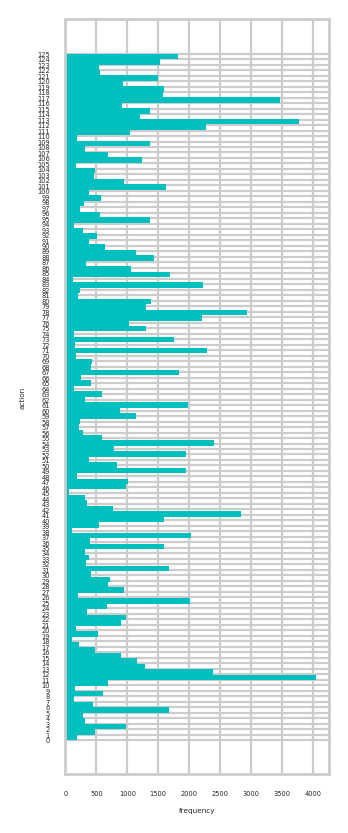

In [9]:
# creates a barplot showing the action distribution
ticks = np.unique(actions_per_state)
# plt.figure(figsize = (6,1), dpi = 200)
# plt.hist(rhat, bins=126)
# plt.xticks(ticks)
# plt.show()
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=0.3)
plt.figure(figsize = (1.7,5), dpi = 200)
sns.distplot(actions_per_state, bins=126, hist=True, kde=False, axlabel='action', vertical=True,
            hist_kws={"linewidth": 2,
                      "alpha": 1, "color": "c"})
plt.yticks(ticks)
plt.xlabel('frequency')
plt.show()


In [102]:
# processing the data for a heatmap of the value function
# Rhat = [model.predict(np.array(s).reshape(1,-1))[0]
#         for s in unique_states_df.state_norm.tolist()]
Rhat2 = [arr[0] for arr in Rhat]
data_flat = np.array(Rhat2).flatten()
data_mean = np.mean(data_flat)
data_stdev = np.std(data_flat)

#scaled the value function for comparison purposes
Rhat_scaled = [(x - data_mean) / data_stdev for x in Rhat2]


# and storing it in a dataframe
data = pd.DataFrame(data = np.array(Rhat_scaled),columns = np.arange(126).astype(str))

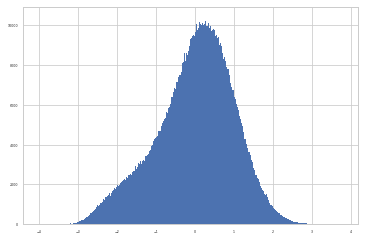

In [103]:
plt.hist(np.array(Rhat_scaled).flatten(), bins = 5000)
plt.show()

118670

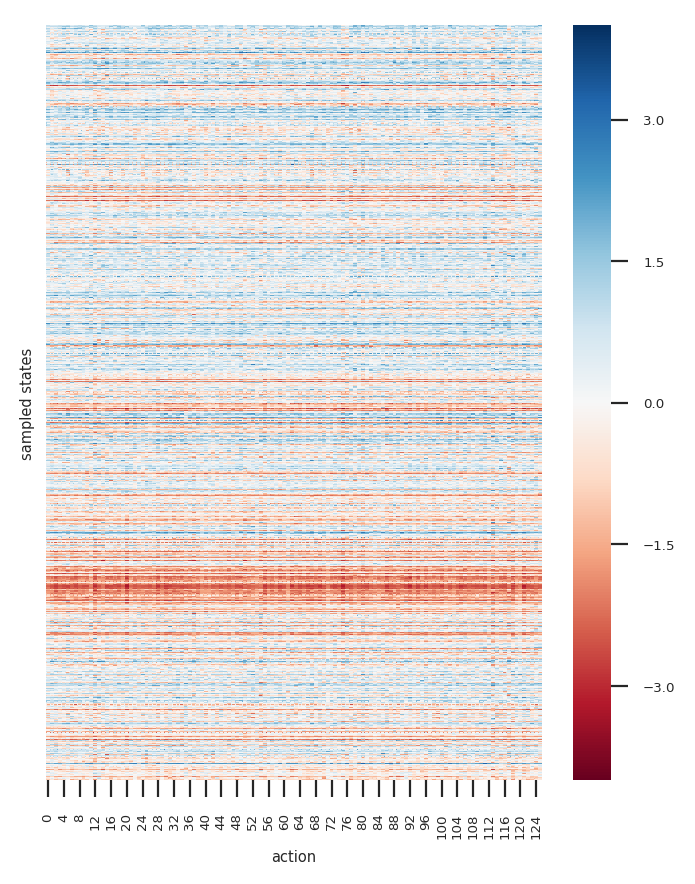

In [104]:
# displaying the heatmap
plt.figure(figsize=(4,5), dpi = 200)
sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=0.6)
# sns.axes_style({'ytick.color': '.5'})
# sns.heatmap(data = data, cmap = 'RdBu', vmin=-10, vmax = +5, center = -4, yticklabels=False)
sns.heatmap(data = data, cmap = 'RdBu', vmin = -4, vmax = +4, yticklabels=False)

plt.xlabel('action')
plt.ylabel('sampled states')
plt.show()